In [1]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA

from asteria.simulation import Simulation
from analysis import *
from plthelper import *

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


In [9]:
for i in range(0):
    print(i)

In [73]:
add_wls = True
detector_scope = "Gen2"

trials = 10000
repetitions = 100


distance = 15*u.kpc
frequency =80*u.Hz # 50 Hz and 400 Hz, in steps of 50 Hz
amplitude = 0.2 # 1% and 50% in log steps (1%, 2%, 5%, 10%, 20%, 50%)
time_start = 150*u.ms
time_end = 300*u.ms
position = "center"

sim_dt = 1 * u.ms
res_dt = 1 * u.ms
time_win = [0, 0.35] * u.s # time independent
freq_res = 1 * u.Hz 
freq_win = [75, 1E6] * u.Hz # freq independent
hanning = False

temp_para = {"frequency": frequency, 
             "amplitude": amplitude, #in percent of max value
             "time_start": time_start,
             "time_end": time_end,
             "position": position}

fft_para = {"time_res": res_dt, 
             "time_win": time_win,
             "freq_res": time_start,
             "freq_win": freq_win,
             "hanning": hanning}


model = {'name': 'Sukhbold_2015',
         'param':{
             'progenitor_mass': 27*u.Msun, 
             'eos': 'LS220'}
        }

sim = Simulation(model=model,
                 distance=10*u.kpc, 
                 res_dt=res_dt,
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0.000*u.s, tmax=1*u.s, dt=sim_dt,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 detector_scope = detector_scope,
                 add_wls = add_wls)
sim.run()

In [75]:
def resort_stat_data(item, filename):
    data = {"ic86" : {"null": [], "signal": []}, "gen2" : {"null": [], "signal": []}, "wls": {"null": [], "signal": []}}

    #quantiles = [0.5, 0.16, 0.84]
    hypothesis = ["null", "signal"]
    for det in ["ic86", "gen2", "wls"]:
        for hypo in hypothesis:
            dd = []
            #for q in np.arange(len(quantiles)):
            for r in range(repetitions):
                d = item[r][hypo][det]
                dd.append(d)
            data[det][hypo] = np.array(dd, dtype=float).reshape(repetitions*trials)

    np.savez(file = filename, 
                reps = repetitions, 
                trials = trials, 
                hypo = hypothesis,
                ic86 = data["ic86"],
                gen2 = data["gen2"],
                wls = data["wls"])
    return data

In [74]:
#Zscore = []
Ts = []
for r in range(repetitions):
    if r%10 == 0: print("Repetition {}/{} for {} trial run".format(r+1, repetitions, trials))
    # Initialize analysis class and run analysis
    ana = Analysis(sim, res_dt = res_dt, distance=distance, trials = trials, temp_para=temp_para)
    ana.run(mode = "FFT", ft_para = fft_para, model = "generic")
    Ts.append(ana.ts)

#Zscore = resort_stat_data(Zscore, filename = "./files/stat_error_{}tri_{}rep.npz")
Ts = resort_stat_data(Ts, filename = "./files/ts_samples_{:1.0e}_distance_{:.0f}kpc.npz".format(int(trials*repetitions), distance.value))

Repetition 1/100 for 10000 trial run
Repetition 11/100 for 10000 trial run
Repetition 21/100 for 10000 trial run
Repetition 31/100 for 10000 trial run
Repetition 41/100 for 10000 trial run
Repetition 51/100 for 10000 trial run
Repetition 61/100 for 10000 trial run
Repetition 71/100 for 10000 trial run
Repetition 81/100 for 10000 trial run
Repetition 91/100 for 10000 trial run


NameError: name 'resort_stat_data' is not defined

In [78]:
Ts = np.load("./files/ts_samples_{:1.0e}_distance_{:.0f}kpc.npz".format(int(trials*repetitions), distance.value), allow_pickle=True)

Tts = {}
for key in ["ic86", "gen2", "wls"]:
    Tts[key] = Ts[key].item()

In [79]:
def bootstrapping(Ts, det = "ic86", trials = 10000, repetitions = 100):
    zboots = []

    ts_stat_sig = np.array([np.median(Ts[det]["signal"]), np.quantile(Ts[det]["signal"], 0.16), np.quantile(Ts[det]["signal"], 0.84)])
    ts_stat_nul = np.array([np.median(Ts[det]["signal"]), np.quantile(Ts[det]["signal"], 0.16), np.quantile(Ts[det]["signal"], 0.84)])

    z = []
    for r in range(repetitions):
        ts_sig = np.random.choice(Ts[det]["signal"], size = trials, replace = False)
        ts_nul = np.random.choice(Ts[det]["null"], size = trials, replace = False)

        ts_bkg_fit = skewnorm(*skewnorm.fit(ts_nul))
        
        for i in range(3):
            p = ts_bkg_fit.sf(ts_stat_sig[i])
            zz = norm.isf(p/2)
            z.append(zz)

    return np.array(z).reshape(repetitions, 3)

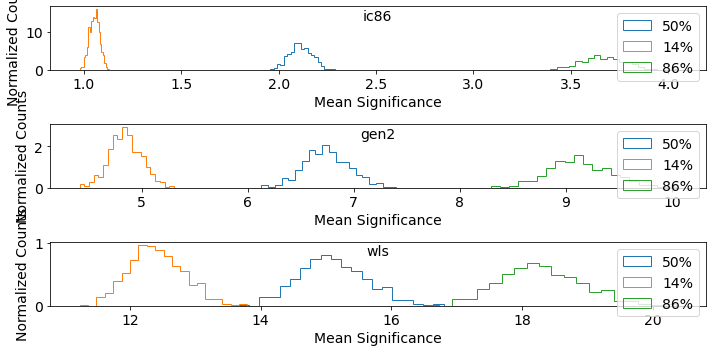

In [83]:
trials = 1000
repetitions = 500

fig, ax = plt.subplots(3,1, figsize = (10,5))

detector = ["ic86", "gen2", "wls"]
colors = ["C0", "C1", "C2"]

for i, det in enumerate(detector):
    Zscore = bootstrapping(Tts, det = det, trials=trials, repetitions=repetitions)
    ax[i].hist(Zscore[:,0], bins = 20, density = True, histtype = "step", color = "C0", label = "50%")#, label = r"{}: {:.1f} $\pm$ {:.1f}".format(det, Zscore[:,i].mean(), Zscore[:,i].std()))
    ax[i].hist(Zscore[:,1], bins = 20, density = True, histtype = "step", color = "C1", label = "14%")#, label = r"{}: {:.1f} $\pm$ {:.1f}".format(det, Zscore[:,i].mean(), Zscore[:,i].std()))
    ax[i].hist(Zscore[:,2], bins = 20, density = True, histtype = "step", color = "C2", label = "86%")#, label = r"{}: {:.1f} $\pm$ {:.1f}".format(det, Zscore[:,i].mean(), Zscore[:,i].std()))
    ax[i].text(0.5, 0.85, s = det, horizontalalignment='center', verticalalignment='center', transform = ax[i].transAxes, fontsize = 14)
    ax[i].set_xlabel("Mean Significance", fontsize = 14)
    ax[i].set_ylabel("Normalized Counts", fontsize = 14)
    ax[i].legend(fontsize = 14, loc = "upper right")
    ax[i].tick_params(labelsize = 14)

plt.tight_layout()


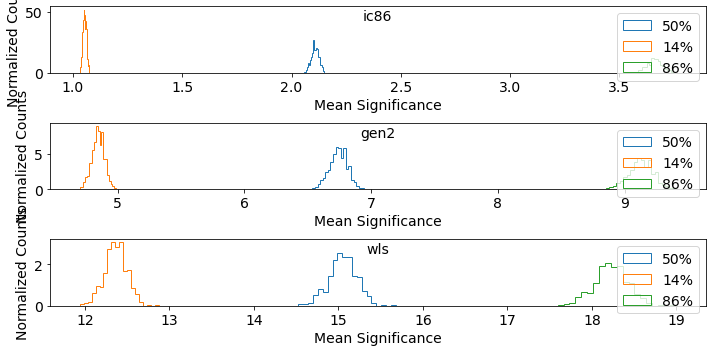

In [84]:
trials = 10000
repetitions = 500

fig, ax = plt.subplots(3,1, figsize = (10,5))

detector = ["ic86", "gen2", "wls"]
colors = ["C0", "C1", "C2"]

for i, det in enumerate(detector):
    Zscore = bootstrapping(Tts, det = det, trials=trials, repetitions=repetitions)
    ax[i].hist(Zscore[:,0], bins = 20, density = True, histtype = "step", color = "C0", label = "50%")#, label = r"{}: {:.1f} $\pm$ {:.1f}".format(det, Zscore[:,i].mean(), Zscore[:,i].std()))
    ax[i].hist(Zscore[:,1], bins = 20, density = True, histtype = "step", color = "C1", label = "14%")#, label = r"{}: {:.1f} $\pm$ {:.1f}".format(det, Zscore[:,i].mean(), Zscore[:,i].std()))
    ax[i].hist(Zscore[:,2], bins = 20, density = True, histtype = "step", color = "C2", label = "86%")#, label = r"{}: {:.1f} $\pm$ {:.1f}".format(det, Zscore[:,i].mean(), Zscore[:,i].std()))
    ax[i].text(0.5, 0.85, s = det, horizontalalignment='center', verticalalignment='center', transform = ax[i].transAxes, fontsize = 14)
    ax[i].set_xlabel("Mean Significance", fontsize = 14)
    ax[i].set_ylabel("Normalized Counts", fontsize = 14)
    ax[i].legend(fontsize = 14, loc = "upper right")
    ax[i].tick_params(labelsize = 14)

plt.tight_layout()

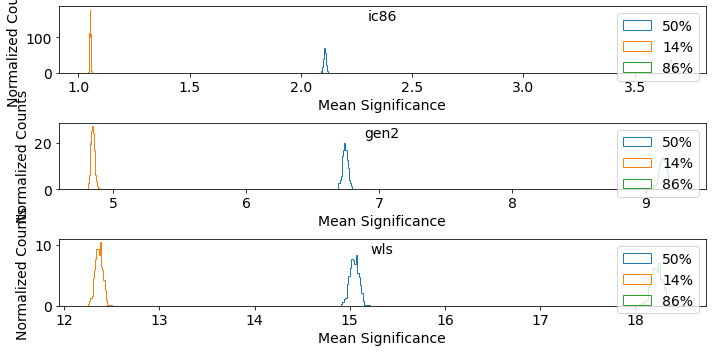

In [85]:
trials = 100000
repetitions = 500

fig, ax = plt.subplots(3,1, figsize = (10,5))

detector = ["ic86", "gen2", "wls"]
colors = ["C0", "C1", "C2"]

for i, det in enumerate(detector):
    Zscore = bootstrapping(Tts, det = det, trials=trials, repetitions=repetitions)
    ax[i].hist(Zscore[:,0], bins = 20, density = True, histtype = "step", color = "C0", label = "50%")#, label = r"{}: {:.1f} $\pm$ {:.1f}".format(det, Zscore[:,i].mean(), Zscore[:,i].std()))
    ax[i].hist(Zscore[:,1], bins = 20, density = True, histtype = "step", color = "C1", label = "14%")#, label = r"{}: {:.1f} $\pm$ {:.1f}".format(det, Zscore[:,i].mean(), Zscore[:,i].std()))
    ax[i].hist(Zscore[:,2], bins = 20, density = True, histtype = "step", color = "C2", label = "86%")#, label = r"{}: {:.1f} $\pm$ {:.1f}".format(det, Zscore[:,i].mean(), Zscore[:,i].std()))
    ax[i].text(0.5, 0.85, s = det, horizontalalignment='center', verticalalignment='center', transform = ax[i].transAxes, fontsize = 14)
    ax[i].set_xlabel("Mean Significance", fontsize = 14)
    ax[i].set_ylabel("Normalized Counts", fontsize = 14)
    ax[i].legend(fontsize = 14, loc = "upper right")
    ax[i].tick_params(labelsize = 14)

plt.tight_layout()

In [4]:
def bpl(x0, alpha, beta, k, x_hist):
    return ((x_hist**alpha)/x0)**(1/k) * (x_hist**beta)/x0

def bpl2(a, b, c, d, x_break, x_hist):
    y = []
    for x in x_hist:
        if x < x_break:
            y.append(a * (x ** b))
        else:
            y.append(c * (x ** d))
    return np.array(y)

In [5]:
def loss_bpl(x, args):
    x_hist, y_hist = args
    
    loss = np.sqrt(np.sum((bpl2(*x, x_hist)-y_hist)**2))
    return loss

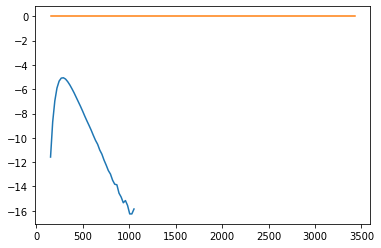

In [11]:
#res = minimize(loss_bpl, x0 = (100,1,-1,10), args = [x_null, np.log(y_null)])
res = minimize(loss_bpl, x0 = (1,1,1,-1,100), args = [x_null, np.log(y_null)])

bpl_fit = res.x
y_fit = bpl2(*bpl_fit, x_fit)

bpl_fit
plt.plot(x_null, np.log(y_null))
plt.plot(x_fit, y_fit)

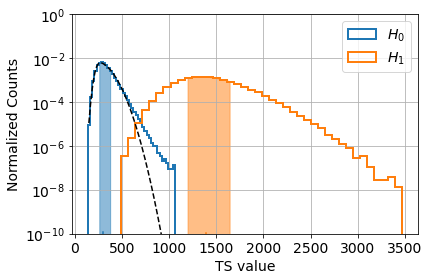

In [31]:
bins = 40
det = "ic86"
# get 16, 50, 86% of TS distribution
ps_null = np.percentile(Tts[det]["null"], [16, 50, 84])
ps_signal = np.percentile(Tts[det]["signal"], [16, 50, 84])

fig, ax = plt.subplots(1,1)

hist_null = plt.hist(Tts[det]["null"], histtype="step", density=True, bins = bins, color = 'C0', lw = 2, label = r"$H_0$")
hist_signal = plt.hist(Tts[det]["signal"], histtype="step", density=True, bins = bins, color = 'C1', lw = 2, label = r"$H_1$")

# get histogram bins and values
bin_null, bin_signal = hist_null[1], hist_signal[1]
y_null, y_signal = hist_null[0], hist_signal[0]
# get x values
x_null, x_signal = (bin_null[1:]+bin_null[:-1])/2, (bin_signal[1:]+bin_signal[:-1])/2


# get fitted background distribution
bkg_fit = skewnorm(*skewnorm.fit(Tts[det]["null"]))
x_fit = np.linspace(np.minimum(x_null[0],x_signal[0]), np.maximum(x_null[-1],x_signal[-1]), 200)
y_fit = bkg_fit.pdf(x_fit)

"""
# get fitted broken power law function
res = minimize(loss_bpl, x0 = (1,1,1,1), args = [x_null, y_null])
bpl_fit = res.x
y_fit = bpl(**bpl_fit, x_fit)
"""

# mask range of 16% and 84% quantiles
mask_null = np.logical_and(x_null > ps_null[0], x_null < ps_null[2])
mask_signal = np.logical_and(x_signal > ps_signal[0], x_signal < ps_signal[2])

hi_null = y_null[np.searchsorted(x_null, ps_null, side='left')-1]
hi_signal = y_signal[np.searchsorted(x_signal, ps_signal, side='left')-1]

ax.plot(x_fit, y_fit, "k--")

ax.fill_between(x = x_signal[mask_signal], y1 = y_signal[mask_signal], color = 'C1', alpha = 0.5)
ax.fill_between(x = x_null[mask_null], y1 = y_null[mask_null], color = 'C0', alpha = 0.5)

ax.set_xlabel("TS value", fontsize = 14)
ax.set_ylabel("Normalized Counts", fontsize = 14)
#ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-10, 1)

# Search for the heights of the bins in which the percentiles are
_, ymax = ax.get_ybound()

ax.axvline(ps_null[1], ymin = 0, ymax = hi_null[1]/ymax, color = 'C0', ls = '-')
ax.axvline(ps_signal[1], ymin = 0, ymax = hi_signal[1]/ymax, color = 'C1', ls = '-')

ax.tick_params(labelsize = 14)
ax.grid()
ax.legend(fontsize = 14)

plt.tight_layout()

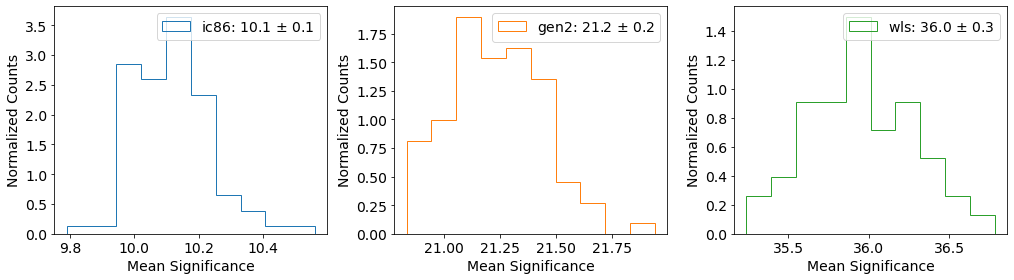

In [48]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize = (14,4))

detector = ["ic86", "gen2", "wls"]
colors = ["C0", "C1", "C2"]

for i, det in enumerate(detector):
    ax[i].hist(Zscore[det][0], bins = 10, density = True, histtype = "step", color = colors[i], label = r"{}: {:.1f} $\pm$ {:.1f}".format(det, Zscore[det][0].mean(), Zscore[det][0].std()))
    ax[i].set_xlabel("Mean Significance", fontsize = 14)
    ax[i].set_ylabel("Normalized Counts", fontsize = 14)
    ax[i].legend(fontsize = 14, loc = "upper right")
    ax[i].tick_params(labelsize = 14)

plt.tight_layout()
plt.savefig("./plots/stat_error_{}tri_{}rep.pdf".format(trials, repetitions))

In [43]:
Zscore[det][0].mean()

10.118559259067956